In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
mallards=pd.read_excel("Mallards_initial data.xlsx")
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.to_excel("mallards_labels.xlsx", index=False)

In [8]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [9]:
# drop last two rows from ordered dataframe
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [10]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [11]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [12]:
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [13]:
X_train.shape

(15929, 6)

In [14]:
scaler = StandardScaler()

In [15]:
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [16]:
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [17]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

# drop the original datetime columns
X_train_scaled_df = X_train_scaled_df.drop(['date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['date'], axis=1)

In [18]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
11284,0.030042,-0.524242,0.125260,0.133639,21,5
11964,0.138355,-0.524242,0.127363,0.126657,19,0
5390,-0.879784,-0.524242,0.125449,0.134608,15,4
860,-1.356359,-0.524242,0.124414,0.135708,18,2
15795,0.939869,-0.524242,0.125983,0.133088,3,0


In [19]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
16564,1.113169,1.907515,0.123946,0.131636,21,4
19327,1.849695,1.907515,-4.781471,-1.732344,10,0
15022,0.874881,-0.524242,0.126517,0.128668,0,3
2457,-1.139734,-0.524242,0.124135,0.135700,5,1
9210,-0.229908,-0.524242,0.121909,0.135181,17,5


In [20]:
n_units = 32
activation = 'relu'
loss_function = 'mean_squared_error'

In [21]:
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [22]:
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [23]:
print(X_train_scaled_df.values.shape)

(15929, 6)


In [24]:
print(y_lat_train.values.shape)

(15929,)


In [25]:
print(modelLat.input_shape)

(None, 6)


In [26]:
X_train_scaled_df.shape

(15929, 6)

In [27]:
X_test_scaled_df.shape

(3983, 6)

In [28]:
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=50)

Epoch 1/50
498/498 [==============================] - 1s 3ms/step - loss: 1490.1783 - val_loss: 438.8575
Epoch 2/50
498/498 [==============================] - 1s 2ms/step - loss: 337.7913 - val_loss: 255.5188
Epoch 3/50
498/498 [==============================] - 1s 3ms/step - loss: 203.1502 - val_loss: 146.1122 - ETA: 0s - loss: 22 - ETA: 0s - loss: 21
Epoch 4/50
498/498 [==============================] - 1s 2ms/step - loss: 96.8750 - val_loss: 50.2968
Epoch 5/50
498/498 [==============================] - 1s 2ms/step - loss: 25.9824 - val_loss: 10.8048
Epoch 6/50
498/498 [==============================] - 1s 2ms/step - loss: 5.7151 - val_loss: 2.9800
Epoch 7/50
498/498 [==============================] - 1s 2ms/step - loss: 1.9079 - val_loss: 1.2637
Epoch 8/50
498/498 [==============================] - 1s 3ms/step - loss: 0.9517 - val_loss: 0.7384
Epoch 9/50
498/498 [==============================] - 1s 2ms/step - loss: 0.6140 - val_loss: 0.5204
Epoch 10/50
498/498 [====================

In [29]:
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=50)

Epoch 1/50
498/498 [==============================] - 2s 4ms/step - loss: 87.1164 - val_loss: 20.1976
Epoch 2/50
498/498 [==============================] - 1s 3ms/step - loss: 15.2007 - val_loss: 10.6277
Epoch 3/50
498/498 [==============================] - 1s 3ms/step - loss: 6.2883 - val_loss: 2.0116
Epoch 4/50
498/498 [==============================] - 1s 2ms/step - loss: 0.7242 - val_loss: 0.2458
Epoch 5/50
498/498 [==============================] - 1s 3ms/step - loss: 0.1681 - val_loss: 0.1233
Epoch 6/50
498/498 [==============================] - 1s 2ms/step - loss: 0.0959 - val_loss: 0.0851
Epoch 7/50
498/498 [==============================] - 1s 2ms/step - loss: 0.0684 - val_loss: 0.0608
Epoch 8/50
498/498 [==============================] - 1s 2ms/step - loss: 0.0530 - val_loss: 0.0473
Epoch 9/50
498/498 [==============================] - 1s 3ms/step - loss: 0.0421 - val_loss: 0.0376
Epoch 10/50
498/498 [==============================] - 1s 3ms/step - loss: 0.0341 - val_loss: 0.

In [30]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.02104539984670261
Root Mean Squared Error (RMSE): 0.1033128701734778


In [31]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.09408607867451559
Root Mean Squared Error (RMSE): 0.39266630702270267


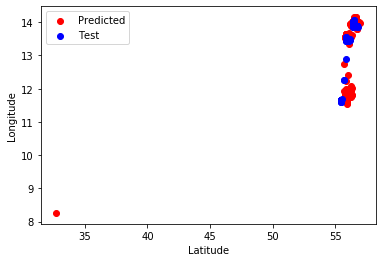

In [32]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='Test')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [33]:
X_test["population"].shape

(3983,)

In [34]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [35]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [36]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [37]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [38]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [39]:
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [40]:
combined_df = combined_df.dropna()

In [41]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.607670,13.957044,56.439716,13.991791
3,88.0,56.525455,13.990786,56.441143,13.988527
6,131.0,56.593056,13.977674,56.439716,13.992242
17,27.0,56.527592,13.974379,56.439903,13.992476
19,23.0,56.576450,13.967064,56.439484,13.992446
31,67.0,56.558636,13.990539,56.439350,13.992638
34,24.0,56.512249,13.985550,56.440166,13.992716
35,131.0,56.605911,13.982323,56.439930,13.992993
41,152.0,56.469166,14.029999,56.440140,13.992735
42,152.0,56.509449,14.018776,56.440044,13.992678


In [42]:
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [43]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.469166,14.029999,56.440140,13.992735
42,152.0,56.509449,14.018776,56.440044,13.992678
181,152.0,56.467979,14.031431,56.440220,13.992155
218,152.0,56.468418,14.017408,56.440342,13.992517
257,152.0,56.055695,13.349698,56.439884,13.991575
449,152.0,56.453106,13.993573,56.439644,13.992051
466,152.0,56.470463,14.001313,56.439968,13.992618
836,152.0,56.464039,14.003254,56.439949,13.992587
1010,152.0,56.523533,13.997766,56.439953,13.993013
1063,152.0,56.474842,13.987989,56.439720,13.992579


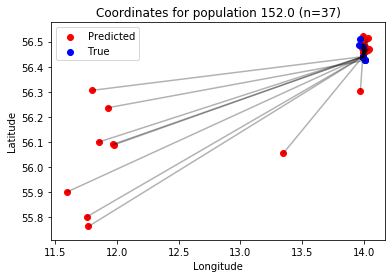

In [44]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [47]:
most_frequent_pop_df.shape

(37, 5)